## Make_More V3
#### Bulding our own loss.backward()


In [76]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from networkx.classes import non_edges
from sympy import hermite_prob
from torch import nn
# from Transformers.NanoGPT import vocab_size
%matplotlib inline


In [77]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [78]:
len(words)

32033

In [79]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [80]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 3]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 3]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 3]), Yte: torch.Size([22706])


In [81]:
# Function Used to comparing manual gradients with Pytorch Gradients
def cmp(s, dt , t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [82]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# -------------Embeddings --------------------
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [83]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [84]:
Xb.shape

torch.Size([32, 3])

In [103]:
# Forward pass, "chunkated" into smaller steps that are possible to backward one at a time
# ---------------Getting the Embeddings of character contex-------------
emb = C[Xb]
embcat = emb.view(Xb.shape[0],-1) # concatenate the vectors

# ----------------Linear Layer 1----------------------
hprebn = embcat @ W1 +b1

#---------------- Batch Norm Layer -------------------
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff*bnvar_inv
hpreact = bngain * bnraw + bnbias

# -----Non-linearity----------------------
h = torch.tanh(hpreact) # hidden layer

#---------Linear Layer 2 (27 neurons for 27 char)----------
logits = h @ W2 + b2
print(f'Logits:{logits.shape}')
# ----------------cross entropy loss (same as F.cross_entropy(logits, Yb))----
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtracting logits from max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv
logprobs = probs.log()
# calculating loss from log probs
loss = -logprobs[range(n), Yb].mean()  # this line plucks the correct next character log probs values as in Yb(index)
print(f'Manually Calculated Loss:{loss}')

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
print(f'Pytorch calculated Loss :{loss}')

Logits:torch.Size([32, 27])
Manually Calculated Loss:3.296250343322754
Pytorch calculated Loss :3.296250343322754


In [104]:
print(f'dlogits :{dlogits.shape}')
print(f'H shape: {h.shape}')
print(f'W2 shape: {W2.shape}')
print(f'b2 shape: {b2.shape}')

dlogits :torch.Size([32, 27])
H shape: torch.Size([32, 64])
W2 shape: torch.Size([64, 27])
b2 shape: torch.Size([27])


In [105]:
# ------------ hpreact = bngain * bnraw + bnbias ------------
print(f'hpreact :{hpreact.shape}')
print(f'bngain :{bngain.shape}')
print(f'bnraw : {bnraw.shape}')
print(f'bnbias :{bnbias.shape}')

hpreact :torch.Size([32, 64])
bngain :torch.Size([1, 64])
bnraw : torch.Size([32, 64])
bnbias :torch.Size([1, 64])


In [73]:
#


torch.Size([1, 64])

In [106]:
# --------backprop : logits = h @ W2 + b2 ---------------
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [110]:
# ------bnraw = bndiff*bnvar_inv --------
print(bnraw.shape)
print(bndiff.shape)
print(bnvar.shape)
print(bnvar_inv.shape)
# -- dbnraw/dbndiff = bnvar_inv*bnraw
dbndiff = bnvar_inv*dbnraw
print(dbndiff.shape)

#------bnvar_inv = (bnvar**2 + 1e-5)**-0.5 --------
dbnvar =  -0.5*(bnvar + 1e-5)**-1.5






torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([32, 64])


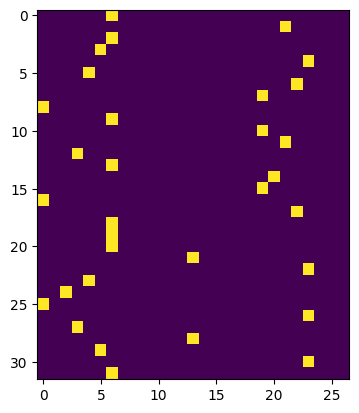

In [60]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [112]:
# ------- Backpropagating through the whole thing manually
# ------- Backprop through exactly all variables
# ------- As we defined in the forward pass one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
#  probs ---> log(probs)------> logprobs ====> dprobs = 1/probs*d(output)
dprobs = (1.0/probs)*dlogprobs # chain rule
dcounts_sum_inv = (counts*dprobs).sum(1, keepdim=True) # summation is due to the replication of counts_sum_inv
# ----- Since the shape of counts and counts_sum_inv are not equal there is a replication of counts_sum_inv to
# all of columns
# C = a*b tensors ====> dc/da = a * chainrule---------------
# a[3x3] , b[3x1]
# a11*b1  a12*b1 a13*b1 # here b is replicating along the all columns of a
# a21*b2  a22*b2 a23*b2 # so for this in backward pass while calculating gradient if same node gives two outputs
# a31*b3 a32*b3  a33*b3 # the gradients have to summ at that node
dcounts = counts_sum_inv * dprobs # counts node is using two branches so we need to sum the gradients
dcounts_sum = -(counts_sum**-2)*dcounts_sum_inv
# ---- counts.sum(1, keepdim=True) here we are using sum for row summing
#  a11 a12 a13 => b1 = a11 + a12 + a13
#  a21 a22 a23 => b2 = a21 + a22 + a23
#  a31 a32 a33 => b2 = a31 + a32 + a33
dcounts += torch.ones_like(counts)*dcounts_sum
dnorm_logits = counts*dcounts
# ---norm_logits = logits - logit_maxes   the shape is not same (logit maxes has [32, 1] which is broadcasting 27 times
# we have to encounter this as we do in the dcounts_sum_inv_
# c11 c12 c13 = a11 a12 a13  - b1
# c21 c22 c23 = a21 a22 a23  - b2 # so dlogits =  1* chain_rule ==dnorm_logits
# c31 c32 c33 = a31 a32 a33  - b3
dlogits = dnorm_logits
dlogit_maxes =  -(dnorm_logits).sum(1, keepdim=True)
# -------------- logits.max(1, keepdim=True)---------
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogit_maxes
# --------backprop : logits = h @ W2 + b2 ---------------
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
# --------- h = torch.tanh(hpreact) --------------- dh/d(z) = 1 - (tanh(z))**2(chainrule) === z= hpreact
dhpreact = (1- h**2)*dh
# --------------------------hpreact = bngain * bnraw + bnbias ------------------------
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = (bngain*dhpreact)
dbnbias = (dhpreact).sum(0, keepdim=True)
# -----------bnraw = bndiff*bnvar_inv -----------------
dbndiff = bnvar_inv*dbnraw
dbnvar_inv = (bndiff*dbnraw).sum(0, keepdim=True)

#------bnvar_inv = (bnvar**2 + 1e-5)**-0.5 --------
dbnvar =  (-0.5*(bnvar + 1e-5)**-1.5)* dbnvar_inv
# Note: When we have a tensor.Sum() in forward pass, => turns to a replication with broadcasting in the backward pass
# Conversely, When there is a replication due broadcast in forward pass => in backward we are going to sum the values

#------------ bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) --------------------
# example :
# a11 a12
# a21 a22
# b1  b2
# b1 = 1/(n-1)*(a11+ a21)
# b2 = 1/(n-1)*(a12 + a22)
dbndiff2 = 1/(n-1)*torch.ones_like(bndiff2)*dbnvar





















cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: False | approximate: True  | maxdiff: 4.190951585769653e-09
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate